In [4]:
import os
import cv2
import time
import uuid
import json
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import albumentations as alb

In [2]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.set_memory_growth(gpu, True)

In [3]:
tf.config.experimental.list_physical_devices("GPU")

[]

In [88]:
images = tf.data.Dataset.list_files("data\\train\\images\*.jpg", shuffle=False)
images.as_numpy_iterator().next()

b'data\\train\\images\\003ec171-b17c-11ef-9778-344b50000000.jpg'

In [89]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img   

In [90]:
images = images.map(load_image)
images.as_numpy_iterator().next()

array([[[121, 110, 104],
        [117, 106, 100],
        [116, 107,  98],
        ...,
        [109, 110,  92],
        [123, 125, 104],
        [124, 127, 106]],

       [[119, 108, 102],
        [117, 108, 101],
        [119, 110, 101],
        ...,
        [117, 118, 100],
        [125, 128, 107],
        [126, 129, 108]],

       [[118, 109, 102],
        [118, 111, 103],
        [120, 113, 103],
        ...,
        [117, 118, 100],
        [123, 126, 105],
        [126, 131, 109]],

       ...,

       [[ 50,  41,  34],
        [ 50,  41,  34],
        [ 51,  42,  37],
        ...,
        [188, 210, 251],
        [189, 208, 250],
        [187, 209, 248]],

       [[ 50,  41,  36],
        [ 49,  40,  35],
        [ 49,  39,  37],
        ...,
        [186, 209, 250],
        [188, 210, 251],
        [188, 211, 252]],

       [[ 51,  41,  39],
        [ 50,  40,  38],
        [ 48,  38,  37],
        ...,
        [184, 207, 249],
        [186, 209, 250],
        [188, 211, 252]]

In [91]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [92]:
image_generator = images.batch(4).as_numpy_iterator()


In [93]:
plot_images = image_generator.next()

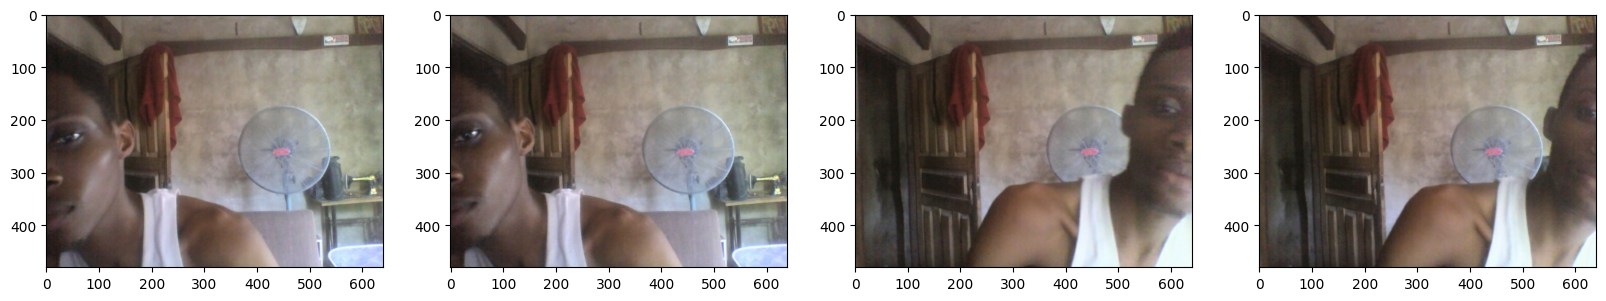

In [94]:
fig,ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [95]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+ '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)
        
    

In [96]:
augmentor = alb.Compose([alb.RandomCrop(width=450,height=450),
                         alb.HorizontalFlip(p = 0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params = alb.BboxParams(format = 'albumentations', label_fields=['class_labels']))

In [97]:
img = cv2.imread(os.path.join('data','train','images','c2ca47f0-b17b-11ef-b4f0-344b50000000.jpg'))
img

array([[[ 77,  73,  85],
        [ 70,  68,  80],
        [ 64,  64,  76],
        ...,
        [161, 179, 186],
        [162, 174, 184],
        [160, 172, 182]],

       [[ 76,  72,  84],
        [ 71,  69,  81],
        [ 65,  67,  78],
        ...,
        [161, 179, 186],
        [163, 176, 184],
        [162, 175, 183]],

       [[ 77,  74,  89],
        [ 72,  72,  86],
        [ 68,  69,  83],
        ...,
        [159, 178, 183],
        [162, 176, 182],
        [161, 175, 181]],

       ...,

       [[ 49,  64,  80],
        [ 50,  65,  81],
        [ 52,  66,  84],
        ...,
        [146, 145, 147],
        [150, 146, 151],
        [149, 148, 150]],

       [[ 48,  65,  78],
        [ 49,  66,  79],
        [ 50,  66,  82],
        ...,
        [147, 143, 148],
        [151, 144, 151],
        [150, 146, 151]],

       [[ 46,  66,  77],
        [ 47,  67,  78],
        [ 47,  66,  79],
        ...,
        [148, 141, 148],
        [150, 143, 150],
        [149, 142, 149]]

In [98]:
with open(os.path.join('data','train','labels','c2ca47f0-b17b-11ef-b4f0-344b50000000.json'), 'r') as f:
    label = json.load(f)

In [99]:
len(label['shapes'])

1

In [100]:
cords = [0,0,0,0]
cords[0] =  label['shapes'][0]['points'][0][0] 
cords[1] =  label['shapes'][0]['points'][0][1] 
cords[2] =  label['shapes'][0]['points'][1][0] 
cords[3] =  label['shapes'][0]['points'][1][1]


In [101]:
cords = list(np.divide(cords, [640,480,640,480]))
          


In [102]:
cords


[np.float64(0.6549622252747251),
 np.float64(0.34546703296703296),
 np.float64(0.8670157967032968),
 np.float64(0.760989010989011)]

In [103]:
augmented = augmentor(image = img, bboxes = [cords], class_labels = ['face'])
    
  

In [104]:
augmented['bboxes']

[[0.7737240770128038, 0.3662759441799588, 1.0, 0.809499388800727]]

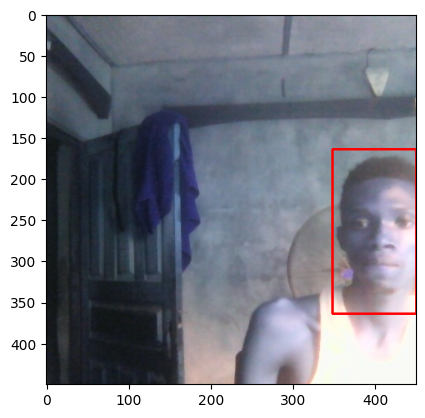

In [105]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0), 2)
plt.imshow(augmented['image'])

In [106]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))
        
        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            
                cords = [0,0,0,0]
                cords[0] =  label['shapes'][0]['points'][0][0] 
                cords[1] =  label['shapes'][0]['points'][0][1] 
                cords[2] =  label['shapes'][0]['points'][1][0] 
                cords[3] =  label['shapes'][0]['points'][1][1]
                
            cords = list(np.divide(cords, [640,480,640,480]))
            
        try:
            for x in range(60):
                augmented = augmentor(image = img, bboxes = [cords], class_labels = ['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'),augmented['image'])
                
                annotation = {}
                annotation['image'] = image
                
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0
                
                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation,f)
                    
        except Exception as e:
            print(e)
                    
            
            

x_max is less than or equal to x_min for bbox [ 2.81507552e-01  9.32692289e-01 -4.44089216e-17  9.98297185e-02
  0.00000000e+00].
y_max is less than or equal to y_min for bbox [0.74854052 0.81593406 0.99843752 0.03507684 0.        ].
y_max is less than or equal to y_min for bbox [0.75626719 0.82394689 0.99843752 0.05456896 0.        ].
y_max is less than or equal to y_min for bbox [0.44290864 0.92467946 0.77858859 0.24244505 0.        ].
x_max is less than or equal to x_min for bbox [0.79490042 0.86858976 0.33731112 0.00206044 0.        ].
y_max is less than or equal to y_min for bbox [0.3158482  0.84455127 0.81292927 0.00206044 0.        ].
x_max is less than or equal to x_min for bbox [0.81808037 0.86973441 0.33915421 0.         0.        ].
x_max is less than or equal to x_min for bbox [0.80262709 0.89606225 0.33216003 0.01236264 0.        ].
x_max is less than or equal to x_min for bbox [0.77000344 0.84798533 0.29867789 0.01694139 0.        ].
x_max is less than or equal to x_min f

In [107]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [108]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [109]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [110]:
train_images.as_numpy_iterator().next()

array([[[0.49509802, 0.4518995 , 0.39718136],
        [0.48707107, 0.45569852, 0.40569854],
        [0.48658088, 0.46519607, 0.4240196 ],
        ...,
        [0.4689951 , 0.45753676, 0.3841912 ],
        [0.5133578 , 0.47512254, 0.37806374],
        [0.46623775, 0.41642156, 0.32996324]],

       [[0.47941175, 0.46292892, 0.40686274],
        [0.47401962, 0.440625  , 0.39846814],
        [0.4788603 , 0.4273897 , 0.39552698],
        ...,
        [0.43425244, 0.41072303, 0.31072304],
        [0.5026348 , 0.4623162 , 0.38308823],
        [0.4903799 , 0.46213236, 0.37034315]],

       [[0.4852941 , 0.44705883, 0.40735295],
        [0.47395834, 0.42248774, 0.38719362],
        [0.45919117, 0.40729168, 0.37199754],
        ...,
        [0.39822304, 0.37126225, 0.30851716],
        [0.43915442, 0.4190564 , 0.34258577],
        [0.5131127 , 0.4867647 , 0.3874387 ]],

       ...,

       [[0.375     , 0.30294117, 0.26813725],
        [0.36905637, 0.29454657, 0.27101716],
        [0.35490197, 0

In [111]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [112]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle= False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [113]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle= False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [114]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle= False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [115]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.     , 0.0794 , 0.04358, 0.972  ], dtype=float16))

In [324]:
train =  tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)


In [325]:
test =  tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [326]:
val =  tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [328]:
data_samples = train.as_numpy_iterator()

In [329]:
res = data_samples.next()
res[1][1][1][:2]

array([0.3594, 0.401 ], dtype=float16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


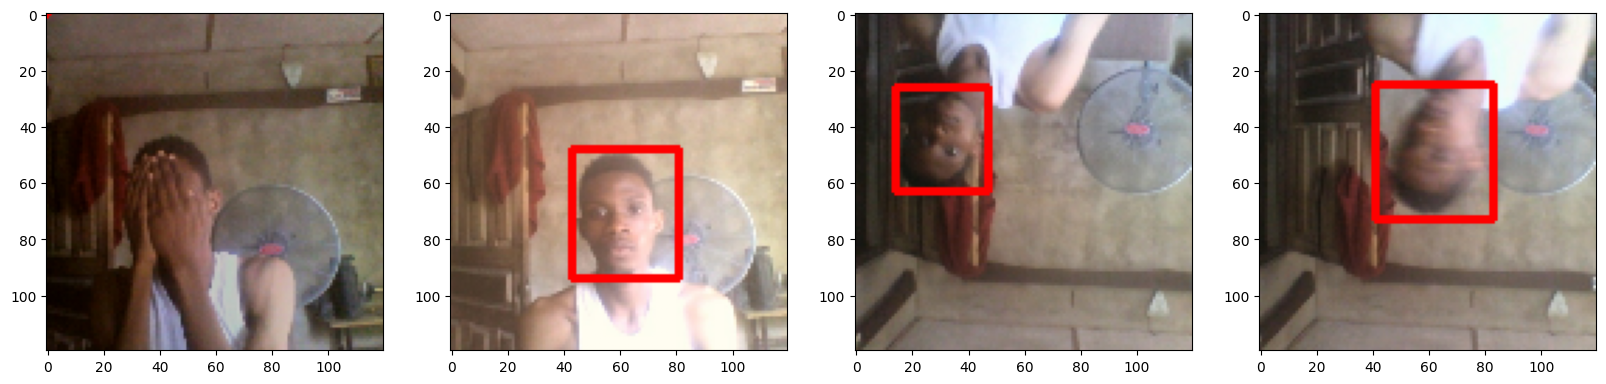

In [330]:
fig,ax = plt.subplots(ncols= 4, figsize = (20, 20))
for idx in range(4):
    sample_image = res[0][idx]
    img = np.copy(sample_image)
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(img,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                  (255,0,0), 2)
   
    ax[idx].imshow(img)

In [152]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [153]:
vgg = VGG16(include_top = False)
vgg.summary

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2068s 35us/step


<bound method Model.summary of <Functional name=vgg16, built=True>>

In [154]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [331]:
def build_model():
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation ='relu')(f1)
    class2 = Dense(1, activation= 'sigmoid')(class1)
    
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation= 'relu')(f2)
    regress2 = Dense(4, activation= 'sigmoid')(regress1)
    
    facetracker = Model(inputs = input_layer, outputs = [class2, regress2])
    return facetracker

In [276]:

facetracker = build_model()

In [277]:
facetracker.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 1)         │      2,049 │ dense_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 4)         │      8,196 │ dense_39[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [278]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [279]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay = lr_decay)

c:\Users\hp\Documents\Ai Projects\New Proj\.venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [280]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
    
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]
    
    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))
    
    return delta_coord + delta_size

In [281]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [346]:
#Training the Model
class FaceTracker(Model):
    # Initalize the model
    def __init__(self, tracker, **kwargs):
        super().__init__(**kwargs)
        self.model = tracker
    # Compile necessary variables for training
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    # Train the model 
    def train_step(self, batch, **kwargs):
        X, y = batch
        
        with tf.GradientTape() as tape:
            # Forward propagation
            classes, coords = self.model(X, training = True)
            
            y[0].set_shape([None,1])
            batch_classloss = self.closs(tf.cast(y[0], tf.float32), tf.cast(classes, tf.float32))
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss + batch_classloss
            # Carry out backpropagation
            grad = tape.gradient(total_loss, self.model.trainable_variables)
            
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        # return Total_loss, Class_loss, and Localization_loss
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
     # Test the model
    def test_step(self, batch, **kwargs):
        X,y = batch
        # Make Predictions 
        classes, coords = self.model(X, training = False)
        y[0].set_shape([None,1])
        batch_classloss = self.closs(tf.cast(y[0], tf.float32), classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + batch_classloss
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)
    

In [347]:
model = FaceTracker(facetracker)

In [348]:
model.compile(opt, classloss, regressloss)

In [349]:
logdir = 'logs'

In [350]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [351]:
hist = model.fit(train, epochs = 40, validation_data = val, callbacks= [tensorboard_callback])

Epoch 1/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 714s 2s/step - class_loss: 0.0402 - regress_loss: 0.1209 - total_loss: 0.1611 - val_class_loss: 0.0381 - val_regress_loss: 0.4006 - val_total_loss: 0.4388
Epoch 2/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 714s 2s/step - class_loss: 0.0198 - regress_loss: 0.0670 - total_loss: 0.0867 - val_class_loss: 8.7242e-04 - val_regress_loss: 0.0152 - val_total_loss: 0.0160
Epoch 3/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 707s 2s/step - class_loss: 0.0175 - regress_loss: 0.0571 - total_loss: 0.0746 - val_class_loss: 0.0774 - val_regress_loss: 0.1760 - val_total_loss: 0.2533
Epoch 4/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 707s 2s/step - class_loss: 0.0100 - regress_loss: 0.0388 - total_loss: 0.0488 - val_class_loss: 6.5134e-04 - val_regress_loss: 0.0133 - val_total_loss: 0.0139
Epoch 5/40
375/375 ━━━━━━━━━━━━━━━━━━━━ 706s 2s/step - class_loss: 0.0063 - regress_loss: 0.0264 - total_loss: 0.0327 - val_class_loss: 6.7694e-05 - val_regress_loss: 0.0166 - val_total_loss: 0.0167
Epoch 6/40
37

In [352]:
hist.history

{'class_loss': [0.013851027935743332,
  8.298073953483254e-05,
  0.00010693194053601474,
  0.000216633066884242,
  0.002911602146923542,
  0.00011612604430411011,
  4.274117236491293e-05,
  0.000953584851231426,
  0.00020049905288033187,
  0.00011486477887956426,
  0.0011238681618124247,
  7.38855087547563e-05,
  0.0027425559237599373,
  2.045296980668354e-07,
  0.0037823570892214775,
  0.0002773568267002702,
  0.00012708302529063076,
  0.0024243295192718506,
  0.001352829160168767,
  9.999107533076312e-06,
  2.0220837541273795e-05,
  0.0015552554978057742,
  0.0014842990785837173,
  5.404275725595653e-06,
  0.00015973221161402762,
  1.2296151908230968e-05,
  4.35934416600503e-05,
  5.618568684440106e-05,
  1.6886893718037754e-05,
  1.4730685506947339e-05,
  6.315169230219908e-06,
  6.974953066674061e-06,
  0.00012783694546669722,
  1.3084979855193524e-06,
  1.4007870049681515e-05,
  0.001395963947288692,
  0.00012724564294330776,
  1.887125472421758e-05,
  1.7159962226287462e-05,
  3.

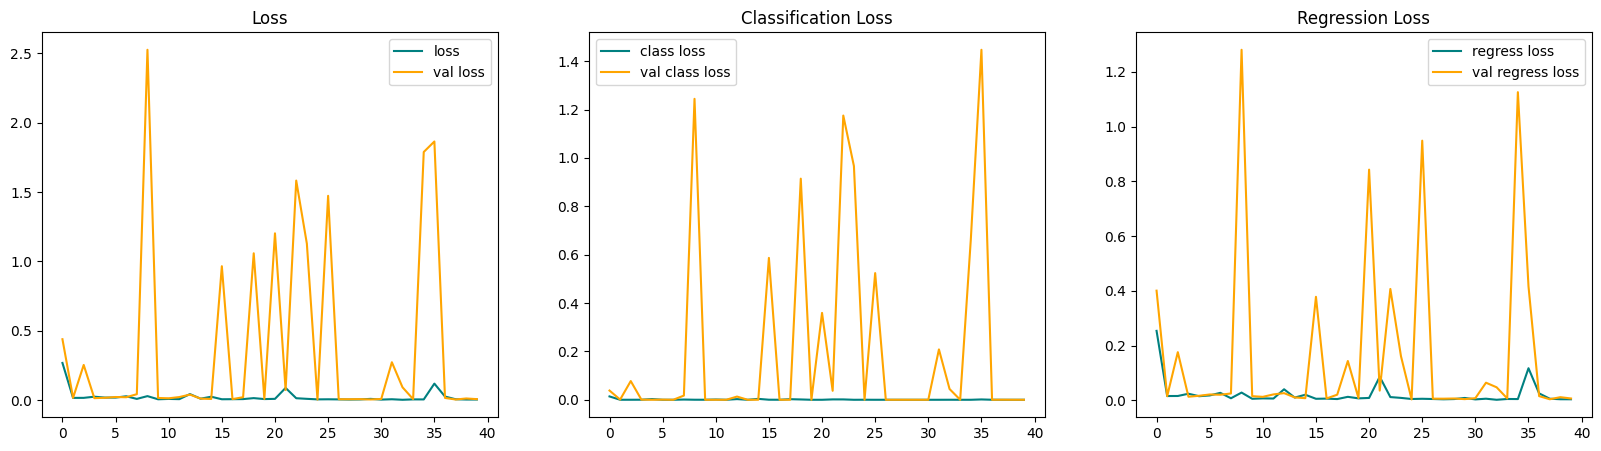

In [353]:
fig, ax = plt.subplots(ncols= 3, figsize = (20,5))

ax[0].plot(hist.history['total_loss'], color = 'teal', label = 'loss')
ax[0].plot(hist.history['val_total_loss'], color = 'orange', label = 'val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color = 'teal', label = 'class loss')
ax[1].plot(hist.history['val_class_loss'], color = 'orange', label = 'val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color = 'teal', label = 'regress loss')
ax[2].plot(hist.history['val_regress_loss'], color = 'orange', label = 'val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [361]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


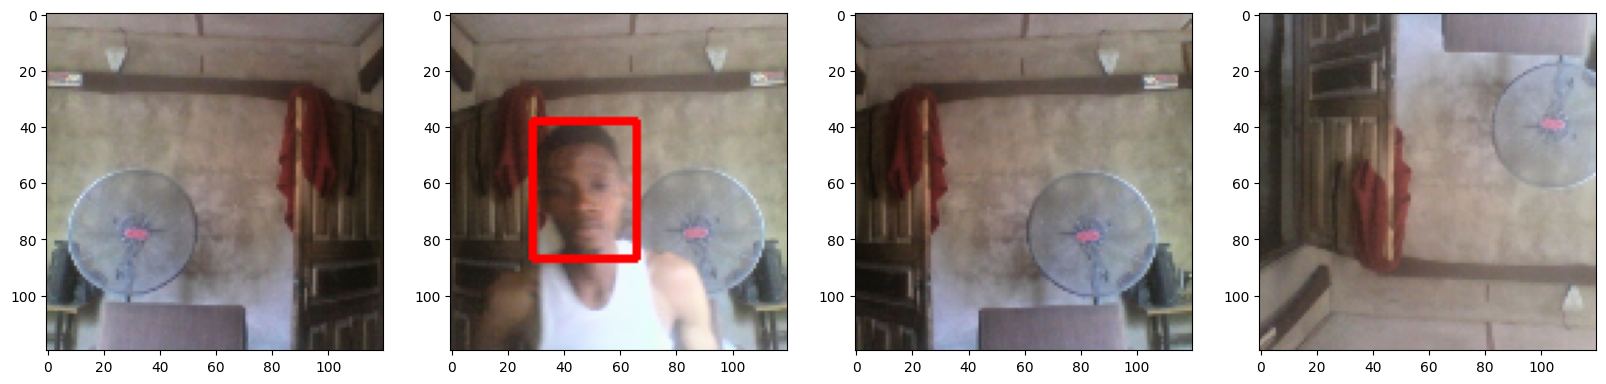

In [362]:
fig, ax = plt.subplots(ncols =4, figsize= (20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    img = np.copy(sample_image)
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.5:
        cv2.rectangle(img,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                      (255,0,0), 2)
        
    ax[idx].imshow(img)

In [1]:
from tensorflow.keras.models import load_model

In [364]:
facetracker.save('facetracker.h5')